<a href="https://colab.research.google.com/github/vkjadon/State-Estimation/blob/main/4-kalmanFilter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kalman filter

Kalman filter update the theoretically predicted state by taking into account the measured state and theoretically predicted state in appropriate proportion.  

The state of the system is $\mathbf{x}_k$; The state is defined by means and the variances of the various components of the state. So, we can write $\mathbf{x}_k \sim \mathcal{N}(\mathbf{\mu_k}, \mathbf{P_k})$.  

The componets of the state would depends on the process of state model. In case of robot, the process or state model is the motion model. We can represent the motion model in terms of displacement and velocity state. In such case, the state components would be as below:
* for 1D $ ~ x_k = \begin{bmatrix} p_x \\ p^{'}_x\end{bmatrix} $. 

* for 2D $ ~ x_k = \begin{bmatrix} p_x \\ p_y \\ p^{'}_x \\ p^{'}_y\end{bmatrix} $

In case of mobile robot, the state is position and velocity, but it could be data about the amount of fluid in a tank, the temperature of a car engine, the position of a user’s finger on a touchpad, or any number of things you need to keep track of.

## KF Algorithm

**Step-1: Initialize the parameter and covariance estimates**:

----
Initial states, $\hat{\mathbf{x}}_0 = E\left[\mathbf{x}\right]$  

Initial state covariance matrix, $\mathbf{P}_0 = E\left[(\mathbf{x} - \hat{\mathbf{x}}_0)(\mathbf{x} - \hat{\mathbf{x}}_0)^T\right]$.  

**Step-2: Assume process or motion model and predict the current state using previous estimate**:

----
$$\mathbf{\check{x}}_k = \mathbf{F}\mathbf{\hat{x}}_{k-1}+\mathbf{G}\mathbf{u}_{k-1}+\mathbf{w}_{k}$$ 

Where,   

$\mathbf{\check{x}}_k$; Predicted State matrix using motion model (or process model) at $k^{th}$ time step.  

$\mathbf{\hat{x}}_{k-1}$; Estimated State matrix using filter at $k^{th}$ time step or previous estimate of the state.  

$\mathbf{F}$; State transition matrix.  

$\mathbf{G}$; Input interaction matrix.  

$\mathbf{w}_k$; state noise of covariance $\mathbf{Q}$. $\mathbf{w}_k \sim \mathcal{N}(0, \mathbf{Q})$


$\mathbf{\check{x}}_k$ is the new best estimate made from previous best estimate ($\mathbf{\hat{x}}_{k-1}$), plus a corrections ($\mathbf{F}$ and $\mathbf{G}$) for known external influences ($\mathbf{u}_{k-1}$).

**Step-3: Calculate process or state covariance matrix using the previous process or state covariance and the given state noise covariance**:

----
$$\mathbf{\check{P}}_k = \mathbf{F\hat{P}_{k-1}F^T}+\mathbf{Q}_k$$ 

Where,   

$\mathbf{\check{P}}_k$; Predicted State covariance matrix at $k^{th}$ time step.  

$\mathbf{\hat{P}}_{k-1}$; Estimated State covariance matrix at $(k-1)^{th}$ time step.  

$\mathbf{Q}$; State covariance matrix. 

And the new uncertainty ($\mathbf{\check{P}}_k$) is predicted from the old uncertainty ($\mathbf{\hat{P}}_{k-1}$), with some additional uncertainty from the environment($\mathbf{Q}_k$).

**Step-4: Assume measurement model**:

----
$$\mathbf{y}_k = \mathbf{H}\mathbf{x}_k+\mathbf{v}_k$$

Where,   

$\mathbf{y}_k$; New measurement at $k^{th}$ time step.  

$\mathbf{H}$; Measurement sensor-state interaction matrix. 

$\mathbf{v}_k$; measurement noise of covariance $\mathbf{R}$. i.e. $\mathbf{v}_k \sim \mathcal{N}(0, \mathbf{R})$

**Step-5: Calculate the Kalman gain matrix for every measurement k**:

----
  * Calculate the gain term: $$\mathbf{K}_k = \mathbf{\check{P}}_{k}\mathbf{H}\left(\mathbf{H}\mathbf{\check{P}}_k\mathbf{H}^T + \mathbf{R}\right)^{-1}$$   

**Step-6: Update estimate of the state $\mathbf{\hat{x}_k}$ and state covariance $\mathbf{P}_k$ for every measurement k**:

----
  * Update the state estimate: $$\hat{\mathbf{x}}_k = \check{\mathbf{x}}_k + \mathbf{K}_k\left(\mathbf{y}_k - \mathbf{H}\check{\mathbf{x}}_k\right)$$

  * Update the state covariance estimate: $$\mathbf{\hat{P}}_k = \left(\mathbf{I} - \mathbf{K}_k\mathbf{H}\right)\mathbf{\check{P}}_{k-1}$$

**Example 1: estimating robot position with KF**

We have a robot equipped with sensors to directly measure the $(x,y)$ location of the robot in the room. The state of the robot is its $x$ and $y$ position in the room, and the control inputs are the velocity in each direction $v_x$ and $v_y$. The following matrices are given.

$F = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} $

$ G =  \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} $

$ Q =  \begin{bmatrix} 0.3 & 0 \\ 0 & 0.3 \end{bmatrix} $

$ H =  \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} $

$ R =  \begin{bmatrix} 0.75 & 0.0 \\ 0.0 & 0.6 \end{bmatrix} $

The robot is initialized at $(x,y) = (0,0)$, and moves by applying constant control inputs $v_x = v_y = 1$ for 10 time steps. Assume the initial belief state as the following:

$$ x_0 =  \begin{bmatrix} 0 \\ 0 \end{bmatrix} $$

$$ P_0 =  \begin{bmatrix} 0.1 & 0\\ 0 & 0.1 \end{bmatrix} $$

Task: use Kalman filter to get a better estimate of where the robot is at each time step!

**Understanding the problem**

To understand the problem and motivate our desire to use Kalman filter, let's plot and compare the ideal trajectory with motion model trajectory as well as some possible measurements that we would get using the available sensors according to their specifications. Since we are not using an actual robot with a sensor, we will simulate the sensor measurements using the measurement model.

In [78]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [79]:
# state = [x_pos, y_pos]
num_steps = 10
ground_truth_xs = np.linspace(0, 10, num=num_steps + 1) # [0, 1, ..., 10]
ground_truth_ys = ground_truth_xs.copy() # x = y
ground_truth_states = np.stack((ground_truth_xs,ground_truth_ys), axis=1) # ground_truth_states is [[0,0], [1,1], ..., [10,10]]

print(ground_truth_states)

[[ 0.  0.]
 [ 1.  1.]
 [ 2.  2.]
 [ 3.  3.]
 [ 4.  4.]
 [ 5.  5.]
 [ 6.  6.]
 [ 7.  7.]
 [ 8.  8.]
 [ 9.  9.]
 [10. 10.]]


In [80]:
# Simulate motion with our noisy motion model
u_t = np.array([1.0, 1.0]) # given constant control input
F = np.array([[1, 0],
              [0, 1]])
G = np.array([[1, 0],
              [0, 1]])
Q = np.array([[0.3, 0],
              [0, 0.3]]) # given Q matrix


In [81]:
x_0, y_0 = 0, 0 # given initial position at (0,0)
motion_states = [np.array([x_0, y_0])] # a list to store state at each step following noisy motion model
print(motion_states[-1])
for i in range(10):
    motion_noise = np.random.multivariate_normal(mean=np.array([0,0]), cov=Q) # ~N(0,Q)
    print("Process Noise ", motion_noise)
    new_state = F @ motion_states[-1] + G @ u_t + motion_noise # note: a @ b = np.dot(a,b)
    motion_states.append(new_state)
    print(motion_states[-1])

[0 0]
Process Noise  [-0.23532448  0.57191056]
[0.76467552 1.57191056]
Process Noise  [ 0.58823421 -0.60890121]
[2.35290973 1.96300934]
Process Noise  [-0.28283952 -0.28635499]
[3.07007021 2.67665435]
Process Noise  [ 0.15579043 -0.43150077]
[4.22586064 3.24515358]
Process Noise  [-0.42514263  0.33490512]
[4.80071802 4.5800587 ]
Process Noise  [ 0.59321143 -0.26196766]
[6.39392944 5.31809104]
Process Noise  [-0.24784117  0.09741982]
[7.14608827 6.41551086]
Process Noise  [0.50024657 1.08066343]
[8.64633484 8.49617429]
Process Noise  [0.11224712 0.08654789]
[9.75858195 9.58272218]
Process Noise  [-0.9081069   0.40147191]
[ 9.85047505 10.98419409]


In [82]:
# Simulate measurements with our noisy measurement model
# In real life, we are supposed to get these directly from our sensor
H = np.array([[1, 0],
              [0, 1]]) # given H matrix
R = np.array([[0.75, 0],
              [0, 0.6]]) # given R matrix

In [83]:
measurement_states = [np.array([x_0, y_0])] # # a list to store state at each step following noisy measurement model, assume we have perfect initial measurement
for i in range(10):
    measurement_noise = np.random.multivariate_normal(mean=np.array([0,0]), cov=R) # ~N(0,R)
    print("measurement_noise ", measurement_noise)
    new_measurement = H @ ground_truth_states[i+1] + measurement_noise # this is z_t
    measurement_states.append(new_measurement)
    print(measurement_states[-1])

measurement_noise  [-0.55318815 -0.88651488]
[0.44681185 0.11348512]
measurement_noise  [0.14012065 0.21476649]
[2.14012065 2.21476649]
measurement_noise  [-1.20141838  0.58024891]
[1.79858162 3.58024891]
measurement_noise  [0.99836136 0.41941079]
[4.99836136 4.41941079]
measurement_noise  [-0.13503111 -1.30718942]
[4.86496889 3.69281058]
measurement_noise  [0.31407752 0.40173661]
[6.31407752 6.40173661]
measurement_noise  [ 0.60889599 -0.24453968]
[7.60889599 6.75546032]
measurement_noise  [ 0.72810526 -0.05276616]
[8.72810526 7.94723384]
measurement_noise  [0.15093808 0.55007946]
[9.15093808 9.55007946]
measurement_noise  [ 0.16341471 -0.05115058]
[10.16341471  9.94884942]


In [84]:
# Convert motion_states and measurement_states to array so we can plot them easily
motion_states = np.array(motion_states)
measurement_states = np.array(measurement_states)

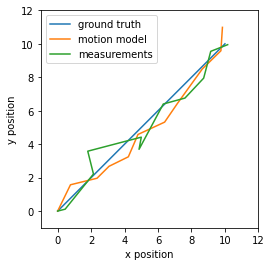

In [85]:
# Compare ground truth and measurements
plt.plot(ground_truth_states[:,0], ground_truth_states[:,1])
plt.plot(motion_states[:,0], motion_states[:,1])
plt.plot(measurement_states[:,0], measurement_states[:,1])
plt.xlim(-1,12)
plt.ylim(-1,12)
plt.xlabel('x position')
plt.ylabel('y position')
plt.legend(['ground truth', 'motion model', 'measurements'])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

As we can see, estimating states using noisy motion model and sensor measurement alone produces noisy state estimates. With Kalman filter, we can get a better state estimates by combining the prediction from motion model and sensor measurements.

Let's implement the Kalman filter! Concretely, we just need to write two functions for the prediction and update steps, and to know when to call these functions.

In [86]:
def predict(F, G, Q, u_t, x_t, P_t):
    predicted_x = F @ x_t + G @ u_t
    predicted_P = F @ P_t @ F.T + Q
    return predicted_x, predicted_P

In [87]:
def update(H, R, y, predicted_x, predicted_P):
    residual_mean = y - H @ predicted_x
    residual_covariance = H @ predicted_P @ H.T + R
    kalman_gain = predicted_P @ H.T @ np.linalg.inv(residual_covariance)
    updated_x = predicted_x + kalman_gain @ residual_mean
    updated_P = predicted_P - kalman_gain @ H @ predicted_P
    return updated_x, updated_P

Let's now run our Kalman filter for 10 time steps!

In [88]:
# Re-initialize the problem with the given information
x_0 = np.array([0, 0])
P_0 = np.array([[0.1, 0], [0, 0.1]])

# Initialize empty lists to store the filtered states and measurements for plotting
measurement_states = []
filtered_states = []

# Run KF for each time step
x_current = x_0.copy()
P_current = P_0.copy()
for i in range(num_steps):
    
    # Predict step
    predicted_x, predicted_P = predict(F, G, Q, u_t, x_current, P_current)
    
    # Get measurement (in real life, we get this from our sensor)    
    measurement_noise = np.random.multivariate_normal(mean=np.array([0,0]), cov=R) # ~N(0,R)
    new_measurement = H @ ground_truth_states[i+1] + measurement_noise # this is z_t
    
    # The rest of update step
    x_current, P_current = update(H, R, new_measurement, predicted_x, predicted_P)
    
    # Store measurements and mu_current so we can plot it later
    measurement_states.append(new_measurement)
    filtered_states.append(x_current)

# For plotting purposes, convert the lists to array
measurement_states = np.array(measurement_states)
filtered_states = np.array(filtered_states) 

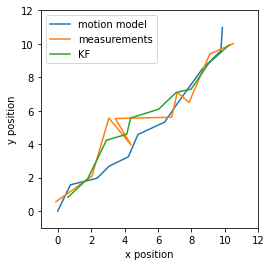

In [89]:
# Let's plot the results

#plt.plot(ground_truth_states[:,0], ground_truth_states[:,1]) # from previous section
plt.plot(motion_states[:,0], motion_states[:,1]) # from previous section
plt.plot(measurement_states[:,0], measurement_states[:,1])
plt.plot(filtered_states[:,0], filtered_states[:,1])
plt.xlim(-1,12)
plt.ylim(-1,12)
plt.xlabel('x position')
plt.ylabel('y position')
#plt.legend(['ground truth', 'motion model', 'measurements', 'KF'])
plt.legend(['motion model', 'measurements', 'KF'])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()